In [1]:
"""
Atividade PEL219 - Perceptron - Gabriel Melo. Matrícula: 125.304-6

Versão Jupyter, para rodar será necessário apenas adicionar os datasets no diretório de execução.

Versão do colab: https://colab.research.google.com/drive/1yVKOYXnKqEZ7JNrrrQqehP4HEyFouFQR?usp=sharing
"""

import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def train_test_split(dataset, test_split_perc=.3, random_seed=None):
    """if not set the seed is the default"""

    #shuffling the dataset
    if random_seed is not None:
        dataset = dataset.sample(frac=1, random_state=random_seed)
    else:
        dataset = dataset.sample(frac=1)

    # setting split size
    split_size = int(math.floor(dataset.shape[0]*test_split_perc))

    # splitting, size!=rows for rowcount use shape
    test = dataset.iloc[0: split_size]
    train = dataset.iloc[split_size: dataset.shape[0]]

    return train, test

In [3]:
def plot_2d_decision_boundary_perceptron(X, label, weights):
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=label)
    
    ymin = np.amin(X[:, 1])
    ymax = np.amax(X[:, 1])
    
    ax.set_ylim([ymin-3, ymax+3])
    
    
    # using the equation https://stats.stackexchange.com/questions/71335/decision-boundary-plot-for-a-perceptron
    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])
    
    x1_1 = (-weights[1] * x0_1 - weights[0]) / weights[2]
    x1_2 = (-weights[1] * x0_2 - weights[0]) / weights[2]
    
    ax.plot([x0_1, x0_2], [x1_1, x1_2], "k")

In [4]:
class Metrics:

    def __init__(self, y, t):
        self.y, self.t = y, t
        self.tn, self.tp, self.fp, self.fn = Metrics.confusion_matrix(self.y, self.t)
        self.accuracy, self.precision, self.recall, self.fscore, self.right = 0, 0, 0, 0, 0

    @classmethod
    def confusion_matrix(cls, y, t):
        tn, tp, fp, fn = 0, 0, 0, 0
        for y_, t in zip(y, t):
            if y_==t and y_==1:
                tp+=1
            elif y_!=t and y_==1:
                fp+=1
            elif y_==t and y_==0:
                tn+=1
            elif y_!=t and y_==0:
                fn+=1
        return tn, tp, fp, fn

    
    def get_accuracy(self):
        self.accuracy = (self.tp + self.tn) / (self.tp + self.fp + self.fn + self.tn)
        return self.accuracy

    def get_precision(self):
        self.precision = (self.tp) / (self.tp + self.fp)
        return self.precision

    def get_recall(self):
        self.recall = (self.tp) / (self.tp + self.fn)
        return self.recall

    def get_fscore(self):
        self.fscore = (2*self.precision*self.recall)/(self.precision + self.recall)
        return self.fscore

    def get_right(self):
        for yi, ti in zip(self.y, self.t):
            self.right += 1 if yi==ti else 0
        return self.right

    def calculate_all(self, as_dict=False):
        self.accuracy, self.precision, self.recall, self.fscore, self.right = \
        self.get_accuracy(), self.get_precision(), self.get_recall(), self.get_fscore(), self.get_right()

        if as_dict:
            return {
                'sample_size': self.t.size,
                'accuracy': self.accuracy,
                'precision': self.precision,
                'recall': self.recall,
                'fscore': self.fscore,
                'is_right': self.right
               }
            
        return self.t.size, self.accuracy, self.precision, self.recall, self.fscore, self.right

In [5]:
class Perceptron:

    def __init__(self, w=None, lr=0.1, tol=1e-3):
        # if you pass the w matrix, the weights will be initialized, if you dont, generate them using the fit function
        self.weights = w
        self.lr = lr
        self.tol = tol

    def add_bias(self, x):
        # checks dimensionality, easier to use
        if x.ndim == 2:
            return np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
        return np.concatenate((np.ones(1), x), axis=0)

    def fit(self, x, t, epoch, early_stop=False):
        # adding bias parameter, it is 1 so its the same as ignoring it
        x = self.add_bias(x)
        
            
        for i in tqdm(range(0, epoch)):
            loss = 0
            for j in range(0, x.shape[0]):

                # prediction, same as predict function
                y = np.heaviside(x[j].dot(self.weights), 0)  

                # creating a deltaw matrix with the learning function Dw_i=n*x_i*(t-o)
                delta_w = np.apply_along_axis(lambda x: self.lr*(t[j] - y)*x, 0, x[j])

                # updating the weights
                self.weights = self.weights + delta_w

                # calculating loss, i'm using the MSE loss
                loss += math.pow((t[j] - y), 2)

            if self.tol >= (loss/x.shape[0]):
                break
                
    def predict(self, x) -> np.array:
        # adding bias parameter, it is 1 so its the same as ignoring it
        x = self.add_bias(x)
        
        # scalar product
        prod = x.dot(self.weights)

        # threshold function, same as an if condition > 0
        return np.heaviside(prod, 0)

# train/test - Simple

In [6]:
# loading the dataset into memory
df_diabetes = pd.read_csv("simple_diabetes.csv") 

# run this cell if you want to use the split train/test
train, test = train_test_split(df_diabetes, random_seed=42)

x_test = test[["plas", "mass"]].values
label_test = test[["class"]].values.flatten()

x_train = train[["plas", "mass"]].values
label_train = train[["class"]].values.flatten()

### init weights as random or zero

In [7]:
clf = Perceptron(w=np.random.randn(x_train.shape[1]+1))

In [8]:
clf.fit(x_train, label_train, 9000)

 13%|██████████▍                                                                   | 1200/9000 [00:01<00:10, 778.16it/s]


In [9]:
# classifying
y_test = clf.predict(x_test)

metrics = Metrics(y_test, label_test)

metrics.calculate_all(as_dict=True), clf.weights

({'sample_size': 30,
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'fscore': 1.0,
  'is_right': 30},
 array([-6.71066878e+02,  5.14369418e+00,  4.93063162e-01]))

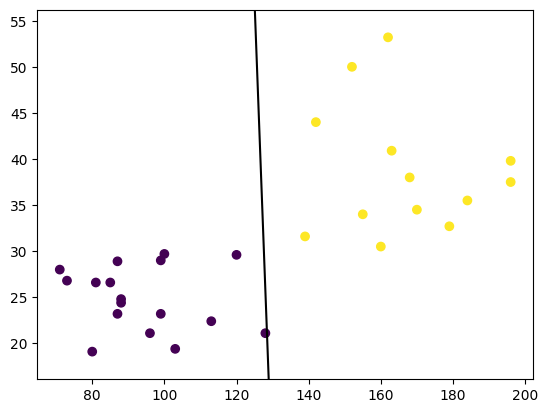

In [10]:
plot_2d_decision_boundary_perceptron(x_test, label_test, clf.weights)

# whole dataset - Simple

In [11]:
# loading the dataset into memory

df_diabetes2 = pd.read_csv("simple_diabetes.csv") 

x2 = df_diabetes2[["plas", "mass"]].values
label2 = df_diabetes2[["class"]].values.flatten()

In [12]:
clf2 = Perceptron(w=np.random.randn(x2.shape[1]+1))

clf2.fit(x2, label2, 9000)

100%|██████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:17<00:00, 511.93it/s]


In [13]:
# classifying
y2 = clf2.predict(x2)

metrics2 = Metrics(y2, label2)

metrics2.calculate_all(as_dict=True), clf2.weights

({'sample_size': 100,
  'accuracy': 0.51,
  'precision': 0.5050505050505051,
  'recall': 1.0,
  'fscore': 0.6711409395973155,
  'is_right': 51},
 array([-718.36520898,   25.00982122,  -34.05550789]))

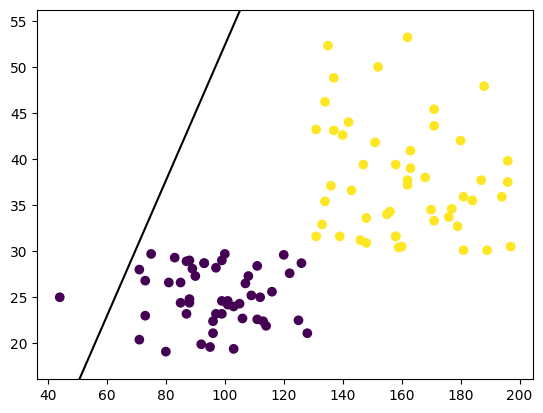

In [14]:
plot_2d_decision_boundary_perceptron(x2, label2, clf2.weights)

# train/test split - Completa

In [15]:
# loading the dataset into memory
df_diabetes3 = pd.read_csv("pima-indians-diabetes.data.csv", header=None) 

# run this cell if you want to use the split train/test
train, test = train_test_split(df_diabetes3, random_seed=42)

In [16]:
x_test3 = test.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7]].values
label_test3 = test.iloc[:, [8]].values.flatten()

x_train3 = train.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7]].values
label_train3 = train.iloc[:, [8]].values.flatten()

In [17]:
clf3 = Perceptron(w=np.random.randn(x_train3.shape[1]+1))

clf3.fit(x_train3, label_train3, 1000)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.00it/s]


In [18]:
# classifying
y3 = clf3.predict(x_test3)

metrics3 = Metrics(y3, label_test3)

metrics3.calculate_all(as_dict=True), clf3.weights

({'sample_size': 230,
  'accuracy': 0.6608695652173913,
  'precision': 0.5555555555555556,
  'recall': 0.125,
  'fscore': 0.20408163265306123,
  'is_right': 152},
 array([-1903.1164286 ,   129.61339667,    24.44390379,   -47.49236959,
           -9.68554831,    -2.99775095,     6.83568745,    95.11404691,
           -3.45761385]))

# whole dataset - Completa

In [19]:
# loading the dataset into memory
df_diabetes4 = pd.read_csv("pima-indians-diabetes.data.csv", header=None) 

x4 = df_diabetes4.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7]].values
label4 = df_diabetes4.iloc[:, [8]].values.flatten()

In [20]:
clf4 = Perceptron(w=np.random.randn(x4.shape[1]+1))

clf4.fit(x4, label4, 1000)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.39it/s]


In [21]:
# classifying
y4 = clf4.predict(x4)

metrics4 = Metrics(y4, label4)

metrics4.calculate_all(as_dict=True), clf4.weights

({'sample_size': 768,
  'accuracy': 0.6901041666666666,
  'precision': 0.5517241379310345,
  'recall': 0.5970149253731343,
  'fscore': 0.5734767025089605,
  'is_right': 530},
 array([-2379.39421427,   141.78707442,    24.35437942,   -32.13306289,
          -23.76970943,    13.12318982,    18.71913518,   461.90974663,
          -12.87394173]))